# Crop out each detected individual from the full sized video frames to use for individual animal keypoint detection

This notebook gets individual position information from the specified tracks file as created in the notebook 'detections_to_tracks.ipynb.' Since every crop produced in this notebook is labeled with the track id it is assosiated with, this step should be done after any manual track correction so those corrections are taken into account in the labels generated here.  

In [1]:
import json
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

# local .json file with local path info
ungulates_root = os.path.dirname(os.getcwd())
local_paths_file = os.path.join(ungulates_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(local_paths['overhead_functions_path'])

import koger_general_functions as kgf
from cropping import create_observation_crop_dicts
from cropping import extract_crops

### This notebook assumes the files are in the format generated by the notebook 'detections_to_tracks.ipynb'

In [2]:
# The crop size, in pixels, centered around the location recorded in the tracks file
crop_size = 160

observation_name = "observation003"
track_filename = "raw_tracks.npy"

# CHANGE BEFORE USING (should be full path to wherever images should be saved)
save_folder = './test' 

# All new projects should use the new style (different naming convention)
new_style = True

if new_style:
    tracks_file = os.path.join(local_paths['processed_folder'], observation_name, 
                               track_filename)
else:   
    tracks_file = os.path.join(local_paths['processed_folder'], observation_name, 
                               "localizations", track_filename)

# Path to frames
frame_folders_root = os.path.join(local_paths['base_frames_folder'], observation_name)
frame_files = kgf.get_observation_frame_files(frame_folders_root)

In [3]:
# We calculate the specs for each crop and save that info in a bunch of dictionaries
# This allows us to use pooling to extract the actual crops in parallel (done a few cells bellow) 

# Note: regarding the crops_per_subfolder variable:
# This notebooks saves possible tens of thousands of small images per tracked animal
# (one small image per frame the animal is observed). Opening a folder with so many files 
# can take a long time so we actually solve the crops for each track in a few subfolders
# so no single folder gets too full. The number of crops saved in each folder is
# specified by crops_per_subfolder.
crop_dicts = create_observation_crop_dicts(frame_files, tracks_file, crop_size, 
                                           save_folder=save_folder, 
                                           crops_per_subfolder=5000)

### Make sure crops look ok before cropping and saving them all

In [4]:
# A valid observation index (same as frame number if observation is single video)
# Just used for the below visualization
obs_ind = 3000
crops = extract_crops(crop_dicts[obs_ind], return_crops=True)
print(f"{len(crops)} crops extracted from observation index {obs_ind}.")

10 crops extracted from observation index 3000.


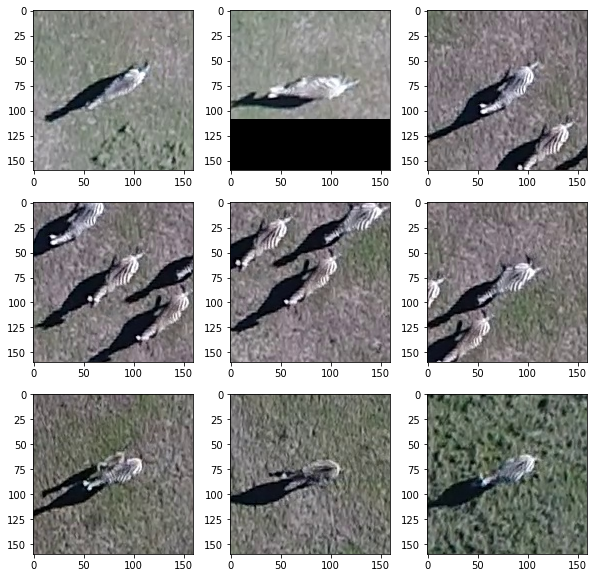

In [5]:
size_grid = 3
fig, axs = plt.subplots(size_grid, size_grid, figsize=(10, 10))
for ax_ind, ax in enumerate(np.ravel(axs)):
    if ax_ind >= len(crops):
        break
    ax.imshow(crops[ax_ind][...,::-1])

### Extract crops from all frames

For increased processing speed, we use Pool to extract the crops in parallel. This could also be done with for loop  if the multiprocessing is causing problems or there aren't too many crops to extract.

In [10]:
from multiprocessing import Pool

num_cores = 8 # SET TO MATCH CORES IN COMPUTER

if __name__ == '__main__':
    with Pool(processes=num_cores-1) as pool:
        pool.map(extract_crops, crop_dicts)
        
# Instead of Pool, can also do this:
# for crop_dict in crop_dicts:
#     extract_crops(crop_dict)